In [1]:
import tensorflow as tf
import glob
import os

# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
# mirrored_strategy = tf.distribute.MirroredStrategy(
#     devices=["/gpu:0", "/gpu:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [2]:
"""Data Pre-processing
"""
import tensorflow as tf
import glob
import os


def get_filenames(isic_dir):
    feature_dir = os.path.join(
        isic_dir, 'ISIC2018_Task1-2_Training_Input', '*.jpg')

    # the dataset actually shuffles here due to arbitrary reading order
    features = glob.glob(feature_dir)
    # make sure the features and labels have the same order
    labels = [f.replace('ISIC2018_Task1-2_Training_Input',
                        'ISIC2018_Task1_Training_GroundTruth').replace('.jpg', '_segmentation.png') for f in features]

    print("Number of images loaded:", len(features), len(labels))
    return features, labels


def split_data(features, labels, validation_split=0.2, test_split=0.2):
    # calculate the split size
    training_split = 1 - (validation_split + test_split)
    num_train = int(training_split * len(features))
    num_val = int(validation_split * len(features))
    num_test = len(features) - num_train - num_val

    print("Number of training images:", num_train)
    print("Number of validation images:", num_val)
    print("Number of test images:", num_test)

    # split the features and labels into training set, validation set and test set
    train_features, val_features, test_features = tf.split(
        features, [num_train, num_val, num_test])
    train_labels, val_labels, test_labels = tf.split(
        labels, [num_train, num_val, num_test])

    return train_features, train_labels, val_features, val_labels, test_features, test_labels


def __load_features(image_file, image_size):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)

    # normalise the image
    image = tf.cast(image, tf.float32) / 255.0
    return image


def __load_labels(label_file, image_size, num_classes):
    label = tf.io.read_file(label_file)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, image_size)

    # convert the label to one-hot encoding
    label = label / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.squeeze(label, axis=2)
    label = tf.one_hot(label, depth=num_classes)
    return label


def __create_dataset(features, labels, image_size, num_classes):
    # create and shuffle dataset
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    dataset = dataset.shuffle(len(features))

    # load features and labels
    dataset = dataset.map(
        lambda feature, label: (__load_features(feature, image_size),
                                __load_labels(label, image_size, num_classes)))

    return dataset


def create_datasets(train_featrues, train_labels, val_features, val_labels,
                    test_features, test_labels, image_size, num_classes):
    """Create the training, validation and test datasets.

    Args:
        train_featrues ([type]): list of training features
        train_labels ([type]): list of training labels
        val_features ([type]): list of validation features
        val_labels ([type]): list of validation labels
        test_features ([type]): list of test features
        test_labels ([type]): list of test labels
        image_size ([type]): image size
        num_classes ([type]): number of classes

    Returns:
        [type]: [description]
    """
    train_set = __create_dataset(train_featrues, train_labels,
                                 image_size, num_classes)
    val_set = __create_dataset(val_features, val_labels,
                               image_size, num_classes)
    test_set = __create_dataset(test_features, test_labels,
                                image_size, num_classes)
    return train_set, val_set, test_set


In [3]:
"""Metrics for training the UNet model
"""
import tensorflow.keras.backend as K
from tensorflow.keras import models, optimizers


def dice_coef(y_true, y_pred) -> float:
    # flatten array for faster computation
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    intersect = K.sum(K.abs(y_true * y_pred))
    total = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    return (2. * intersect + 1.) / (total + 1.)


def dice_loss(y_true, y_pred) -> float:
    return 1 - dice_coef(y_true, y_pred)


def scheduler(epoch, lr):
    pass

In [4]:
"""Improved UNet implementation (2D version)

Reference: https://arxiv.org/abs/1802.10508v1
"""
from tensorflow.keras import layers, models, optimizers
import tensorflow_addons as tfa

def __encoder_module(input, num_filters, strides=(1, 1)):
    conv = layers.Conv2D(num_filters, (3, 3), strides,
                         padding="same", activation=layers.LeakyReLU(0.01))(input)

    # context module (pre-activation residual blocks)
    ctx1 = tfa.layers.InstanceNormalization()(conv)
    ctx1 = layers.Activation(layers.LeakyReLU(0.01))(ctx1)
    ctx1 = layers.Conv2D(num_filters, (3, 3), padding="same")(ctx1)
    ctx_drop = layers.Dropout(0.3)(ctx1)
    ctx2 = tfa.layers.InstanceNormalization()(ctx_drop)
    ctx2 = layers.Activation(layers.LeakyReLU(0.01))(ctx2)
    ctx2 = layers.Conv2D(num_filters, (3, 3), padding="same")(ctx2)

    # element-wise sum
    sum = layers.Add()([conv, ctx2])
    return sum


def __decoder_module(input, encode_output, num_filters, localization_module=True):
    # upsampling module
    up = layers.UpSampling2D((2, 2))(input)
    conv1 = layers.Conv2D(num_filters, (3, 3), padding="same",
                          activation=layers.LeakyReLU(0.01))(up)
    concat = layers.Concatenate()([conv1, encode_output])

    if not localization_module:
        return concat

    # localization module
    conv2 = layers.Conv2D(num_filters, (3, 3), padding="same",
                          activation=layers.LeakyReLU(0.01))(concat)
    conv2 = layers.Conv2D(num_filters, (1, 1), padding="same",
                          activation=layers.LeakyReLU(0.01))(conv2)
    return conv2


def build_model(input_shape):
    inputs = layers.Input(input_shape)

    # downsampling
    down1 = __encoder_module(inputs, 16)
    down2 = __encoder_module(down1, 32, strides=(2, 2))
    down3 = __encoder_module(down2, 64, strides=(2, 2))
    down4 = __encoder_module(down3, 128, strides=(2, 2))
    down5 = __encoder_module(down4, 256, strides=(2, 2))

    # upsampling
    up1 = __decoder_module(down5, down4, 128)
    up2 = __decoder_module(up1, down3, 64)
    up3 = __decoder_module(up2, down2, 32)
    up4 = __decoder_module(up3, down1, 16, localization_module=False)
    conv = layers.Conv2D(32, (3, 3), padding="same",
                         activation=layers.LeakyReLU(0.01))(up4)

    # segmentation layers
    seg1 = layers.Conv2D(1, (1, 1), padding="same",
                         activation=layers.LeakyReLU(0.01))(up2)
    seg1 = layers.UpSampling2D((2, 2), interpolation="bilinear")(seg1)
    seg2 = layers.Conv2D(1, (1, 1), padding="same",
                         activation=layers.LeakyReLU(0.01))(up3)
    seg2 = layers.Add()([seg2, seg1])
    seg2 = layers.UpSampling2D((2, 2), interpolation="bilinear")(seg2)
    seg3 = layers.Conv2D(1, (1, 1), padding="same",
                         activation=layers.LeakyReLU(0.01))(conv)
    seg3 = layers.Add()([seg3, seg2])

    outputs = layers.Activation("sigmoid")(seg3)
    model = models.Model(inputs, outputs, name="AdvUNet")
    return model


class AdvUNet:
    def __init__(self, input_shape):
        self.model = build_model(input_shape)

    def compile(self):
        self.model.compile(optimizer=optimizers.Adam(learning_rate=5e-4),
                           loss=dice_loss, metrics=["accuracy", dice_coef])

    def fit(self, train_dataset, val_dataset, batch_size, epochs):
        return self.model.fit(train_dataset.batch(batch_size), validation_data=val_dataset.batch(batch_size),
                       epochs=epochs, verbose=1)


In [5]:
"""Driver script for Improved UNet
"""

ISIC_DIR = "../datasets/ISIC2018"
IMAGE_HEIGHT = 192
IMAGE_WIDTH = 256

# hyperparameters
NUM_CLASSES = 1
BATCH_SIZE = 32
EPOCHS = 10

# load datasets
features, labels = get_filenames(isic_dir=ISIC_DIR)
train_features, train_labels, val_features, val_labels, test_features, test_labels = split_data(
    features, labels, validation_split=0.2, test_split=0.2)

# create datasets
train_dataset, val_dataset, test_dataset = create_datasets(
    train_features, train_labels, val_features, val_labels,
    test_features, test_labels, [IMAGE_HEIGHT, IMAGE_WIDTH], NUM_CLASSES)

for image, label in train_dataset.take(1):
    print("Dataset shapes:", image.shape, label.shape)
    break

# create model
model = AdvUNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
print(model.model.summary())

# compile and train the model
model.compile()
history = model.fit(train_dataset, val_dataset,
                    batch_size=BATCH_SIZE, epochs=EPOCHS)


Number of images loaded: 2594 2594
Number of training images: 1556
Number of validation images: 518
Number of test images: 520
Dataset shapes: (192, 256, 3) (192, 256, 1)
Model: "AdvUNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 192, 256, 16) 32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activati

In [6]:
# evaluate on the test set
results = model.model.evaluate(test_dataset.batch(BATCH_SIZE), verbose=1)

print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test dice coefficient:", results[2])

17/17 [==============================] - 2s 103ms/step - loss: 0.0281 - accuracy: 0.9437 - dice_coef: 0.9721
[0.028115030378103256, 0.9436604976654053, 0.9721283912658691]


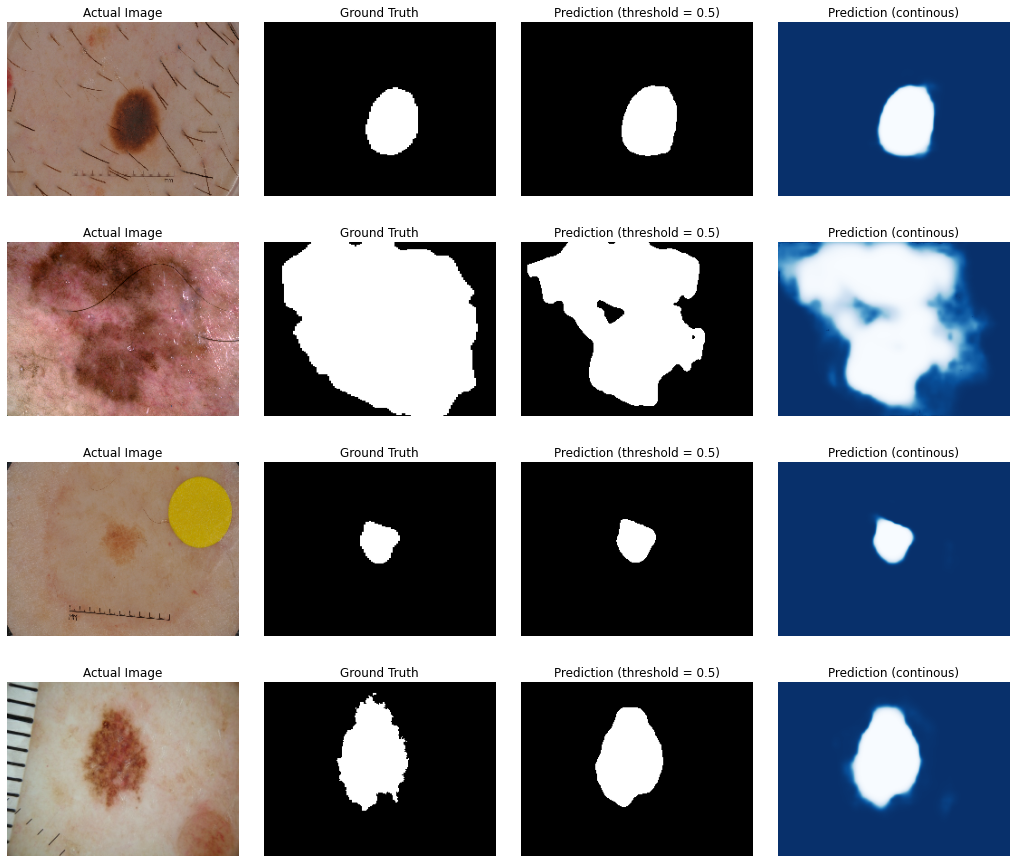

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_predictions(model, test_dataset, plot_batch=4, threshold=0.5):
    # generate predictions
    test_images, test_labels = next(iter(test_dataset.batch(plot_batch)))
    predictions = model.model.predict(test_images)

    # initialise figure
    figure = plt.figure(constrained_layout=True, figsize=(14, 12))
    # add padding to the rows
    figure.set_facecolor('white')
    spec = gridspec.GridSpec(ncols=4, nrows=plot_batch,
                             figure=figure, hspace=0.1, wspace=0.1)

    for i in range(plot_batch):
        # plot original image
        ax1 = figure.add_subplot(spec[i, 0])
        ax1.imshow(test_images[i])
        ax1.set_title("Actual Image")
        ax1.axis('off')

        # plot ground truth
        ax2 = figure.add_subplot(spec[i, 1])
        ax2.imshow(test_labels[i], cmap='binary')
        ax2.set_title("Ground Truth")
        ax2.axis('off')

        # plot prediction with threshold
        ax3 = figure.add_subplot(spec[i, 2])
        ax3.imshow(predictions[i] > threshold, cmap='binary')
        ax3.set_title("Prediction (threshold = {})".format(threshold))
        ax3.axis('off')

        # plot prediction
        ax4 = figure.add_subplot(spec[i, 3])
        ax4.imshow(predictions[i], cmap='Blues')
        ax4.set_title("Prediction (continous)")
        ax4.axis('off')

    figure.savefig("./images/plot.png")
    figure.show()


plot_predictions(model, test_dataset)


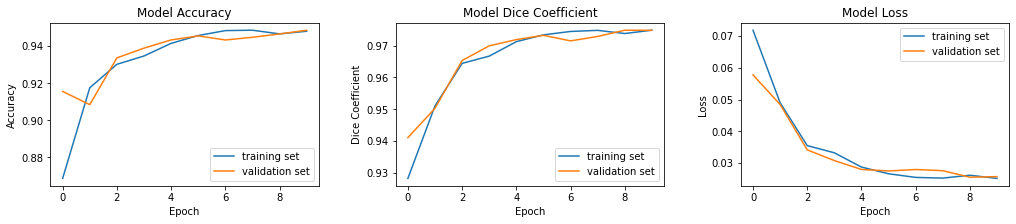

In [20]:
def plot_metrics(history):
    figure = plt.figure(constrained_layout=True, figsize=(14, 3))
    figure.set_facecolor('white')
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=figure, wspace=0.1)
    
    # summarise history for accuracy
    ax1 = figure.add_subplot(spec[0, 0])
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['training set', 'validation set'], loc='lower right')

    # summarise history for dice coefficient
    ax2 = figure.add_subplot(spec[0, 1])
    ax2.plot(history.history['dice_coef'])
    ax2.plot(history.history['val_dice_coef'])
    ax2.set_title('Model Dice Coefficient')
    ax2.set_ylabel('Dice Coefficient')
    ax2.set_xlabel('Epoch')
    ax2.legend(['training set', 'validation set'], loc='lower right')

    # summarise history for loss
    ax3 = figure.add_subplot(spec[0, 2])
    ax3.plot(history.history['loss'])
    ax3.plot(history.history['val_loss'])
    ax3.set_title('Model Loss')
    ax3.set_ylabel('Loss')
    ax3.set_xlabel('Epoch')
    ax3.legend(['training set', 'validation set'], loc='upper right')

    figure.savefig("./images/plot_metrics.png")
    figure.show()


plot_metrics(history)
